## Data Loading

First, we will load the data as it is using pandas into dataframe object. 

In [1]:
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 



In [2]:
train = pd.read_csv('data/train_data.csv')
df = pd.read_csv('data/train_data.csv')


df.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df['bond_id'].unique().shape

(3736,)

In [4]:
_id=1
train_1 = train[train['bond_id'] ==_id] 
print(train_1.shape)
train_1.head()

(28, 61)


,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


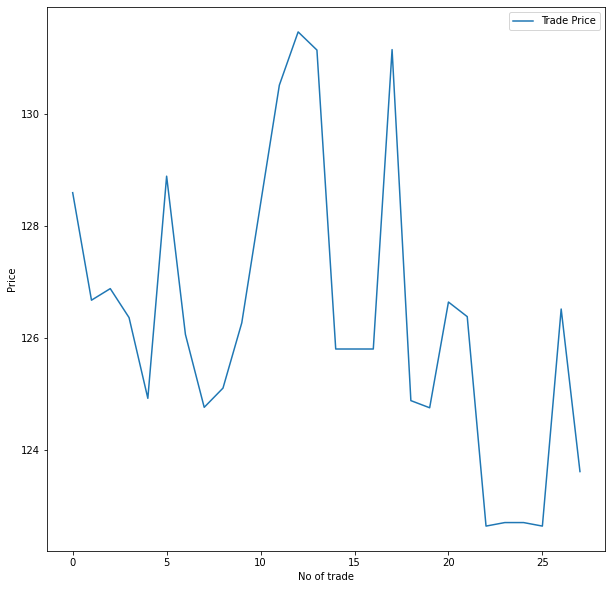

In [18]:
plt.figure(figsize=(10,10))
plt.plot(range(0,len(train_1)),train_1['trade_price'],label='Trade Price') 
plt.ylabel('Price')
plt.xlabel('No of trade')
plt.legend() 
plt.show()

There are 3736 unique bonds present in the data, while we can use this as one Id in real world, but in the Kaggle competition there is no bond_id in the test.csv file so we can either prepare data using it or can drop it. But, dropping bond_id is loosing meaningfful of info, so we will create one function  which we can use for each bond Id to construct time-series data for it an then we will train some models on it. 

## Data Preparation

We can not use id column at all. So we will drop it first. Then we will create one function which can take our dataframe and construct time series data from it. It means that the next trade price will be output for the current trade. This way we will provide the current data to predict the next trade price. 

In [6]:
df.drop('id', axis=1, inplace=True)

In [7]:
def series_to_supervise(df, s=1):
    shifted_df = df.shift(s)
    shifted_df.rename(columns= {'trade_price':'output_trade_price'}, inplace=True)
    y_out = shifted_df['output_trade_price']
    del shifted_df
    
    return pd.concat([df, y_out], axis=1)

In [8]:
grouped = df.groupby(['bond_id'])

We have more than 3000 unique bonds. So for all of those bonds we have to construct the time series data. So, we will use groupby object and then will apply our function to create the time-series data from it. Then we will combine all the data into one dataframe for further usage. 

In [9]:
final_data = []
for name, data in grouped:
    data_sup = series_to_supervise(data)
    data_sup.dropna(subset=['output_trade_price'], inplace=True)
    final_data.append(data_sup)

In [10]:
df_sup = pd.concat(final_data)
print(df_sup.shape)
df_sup.head()

(758942, 61)


,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,curve_based_price,...,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10,output_trade_price
1,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,126.323528,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.596
2,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,126.761433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.673
3,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,127.025765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.880
4,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,125.736081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.362
5,1,128.891,1.479307,5.95,25.981429,0,35.982,29000,4,126.636079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.918


The above dataframe has our last column as output. Now, we do not need bond_id column as it has not useful information for us. Also this column is not present in to the test.csv file for the competition. So, we will try to closely to the competition data. Then, we will scale the data to the range of 0 to 1. This way our model can fit the data best as it is normalized. 

In [11]:
df_sup.drop('bond_id', axis=1, inplace=True)

In [12]:
df_sup.fillna(0,inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(df)

In [13]:
data = scaler.fit_transform(df_sup)

In [14]:
data.shape

(758942, 60)

Now, it is time to split the data into train and test data. We will use 90% of the data to train the model and the rest 10% for testing our model. We are going to use LSTM model so we will reshape our data as per the required shape of the LSTM.  

In [15]:
x = data[:, :-1]
y = data[:, -1]

In [16]:
train_x, test_x = x[:680141, :], x[680141:, :]
train_y, test_y = y[:680141], y[680141:]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(680141, 1, 59) (680141,) (78801, 1, 59) (78801,)


## Model Building 

Now we will bild our model. We are using Keras library for it. It is running on top of the tensorflow. We will create simple LSTM model with one LSTM and one Dense layer for output. In output layer, we will use linear activation as our final output is price, which is float. 

In [12]:
from tensorflow.keras.layers import Dense,LSTM, Activation
from tensorflow.keras.models import Sequential

# Model defination

model = Sequential()
model.add(LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')

ModuleNotFoundError: No module named 'tensorflow'

Now, it is time to train the model. Let's do it. 

In [13]:
model.fit(train_x, train_y,epochs=10, batch_size=32, validation_data=(test_x, test_y), verbose=1, shuffle=False)

NameError: name 'model' is not defined

Now, as our model is trained, let's test it. We will make predictions on the test data and then will check out the root mean square error of the predictions. In the process to do so, we also need to convert the normalized data into raw data. We can do this by using MinMaxScaler inverse_transform function

In [9]:
from math import sqrt 
from sklearn.metrics import mean_squared_error

In [ ]:
preds = model.predict(test_x)

test_X = test_x.reshape((test_x.shape[0], test_x.shape[2]))
print(test_X.shape)
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, :], preds), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse =sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Prediction on some other data

In [ ]:
test_data = test_x[0:5,:,:]
test_truth = test_y[0:5]

In [ ]:
pred = model.predict(test_data)

In [ ]:
test_X = test_data.reshape((test_data.shape[0], test_data.shape[2]))
print(test_X.shape)
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, :], pred), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_truth = test_truth.reshape((len(test_truth), 1))
inv_y = np.concatenate((test_X[:, :], test_truth), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [ ]:
dataframe = pd.DataFrame({'Predicted trade price': inv_yhat, 'Real trade price': inv_y})

In [ ]:
dataframe

The above predicted prices are really close to the real prices. There can be chances of data leakage or some other issue like overfiting of the model. But, it shows to us the potential of LSTM network to predict the trade price of the bonds given the historical data.